#### varaibles
- real gdp per capita growth - trend + cycle of real values? diff og gdp real per capita
- inflation = inflation trend + measurement errors???
- short rate = inflation trend + real rate trend 
- long rate = inflation trend + real rate trend + term trend
- inflation expectations??
- growth expextations??
- 

In [1]:
import Pkg
Pkg.activate("../")

include("../src/TCVAR.jl")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


Main.TCVAR

In [2]:
using .TCVAR
using DataFrames, XLSX, TimeSeries
using Statistics
using LinearAlgebra
using Plots


In [83]:
df = DataFrame(XLSX.readtable("../../../data/usa_macro_data_s.xlsx", "Quarterly", infer_eltypes=true))
data_source = TimeArray(df; timestamp = :observation_date)
data_source = from(data_source, Date(1991, 10, 01))


gdp = percentchange(data_source[:A939RX0Q048SBEA], :log) .* 400
cpi = percentchange(data_source[:GDPDEF], :log) .* 400

data = merge(gdp, cpi, data_source[[:TB3MS, :GS10]])

presample, data = from(to(data, Date(1959, 12, 31)), Date(1955, 01, 01)), from(data, Date(1960, 01,01))
data = to(data, Date(2008, 12, 31))
display(data)

term =  presample[:GS10] .- presample[:TB3MS]
real_rate = presample[:TB3MS] .- presample[:GDPDEF] 

presample = merge(presample[[:A939RX0Q048SBEA, :GDPDEF]], real_rate, term)


68×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1992-01-01 to 2008-10-01
┌────────────┬─────────────────┬──────────┬───────┬──────┐
│            │ A939RX0Q048SBEA │ GDPDEF   │ TB3MS │ GS10 │
├────────────┼─────────────────┼──────────┼───────┼──────┤
│ 1992-01-01 │         3.58144 │  1.48277 │  3.89 │  7.3 │
│ 1992-04-01 │          2.9751 │  2.39944 │  3.68 │ 7.38 │
│ 1992-07-01 │         2.46082 │  1.95253 │  3.08 │ 6.62 │
│ 1992-10-01 │         2.76879 │  2.74039 │  3.07 │ 6.74 │
│ 1993-01-01 │       -0.509118 │  2.23797 │  2.96 │ 6.28 │
│ 1993-04-01 │         1.10553 │  2.37553 │  2.97 │ 5.99 │
│ 1993-07-01 │        0.536985 │  2.36772 │   3.0 │ 5.62 │
│ 1993-10-01 │         4.13496 │  2.17464 │  3.06 │ 5.61 │
│     ⋮      │        ⋮        │    ⋮     │   ⋮   │  ⋮   │
│ 2007-04-01 │         1.54605 │  2.77153 │  4.74 │ 4.85 │
│ 2007-07-01 │         1.25987 │   2.1804 │   4.3 │ 4.73 │
│ 2007-10-01 │          1.4923 │  1.61719 │  3.39 │ 4.26 │
│ 2008-01-01 │        -2.58636 │  1.4778

0×4 TimeArray{Float64, 2, Date, Matrix{Float64}}

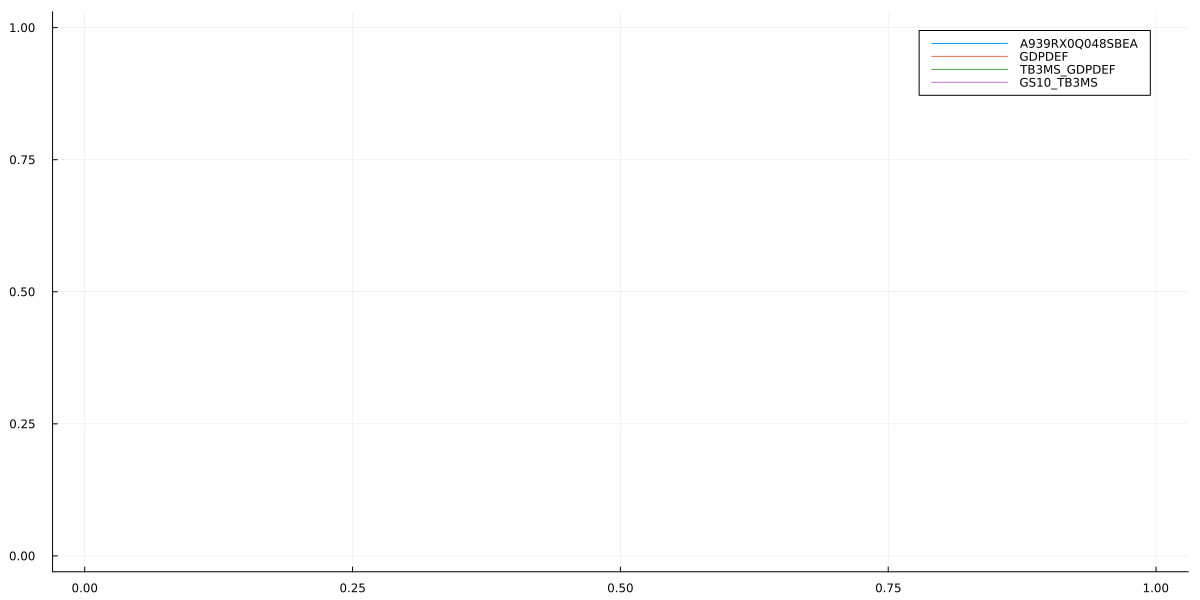

In [84]:
plot(presample; size=(1200, 600))

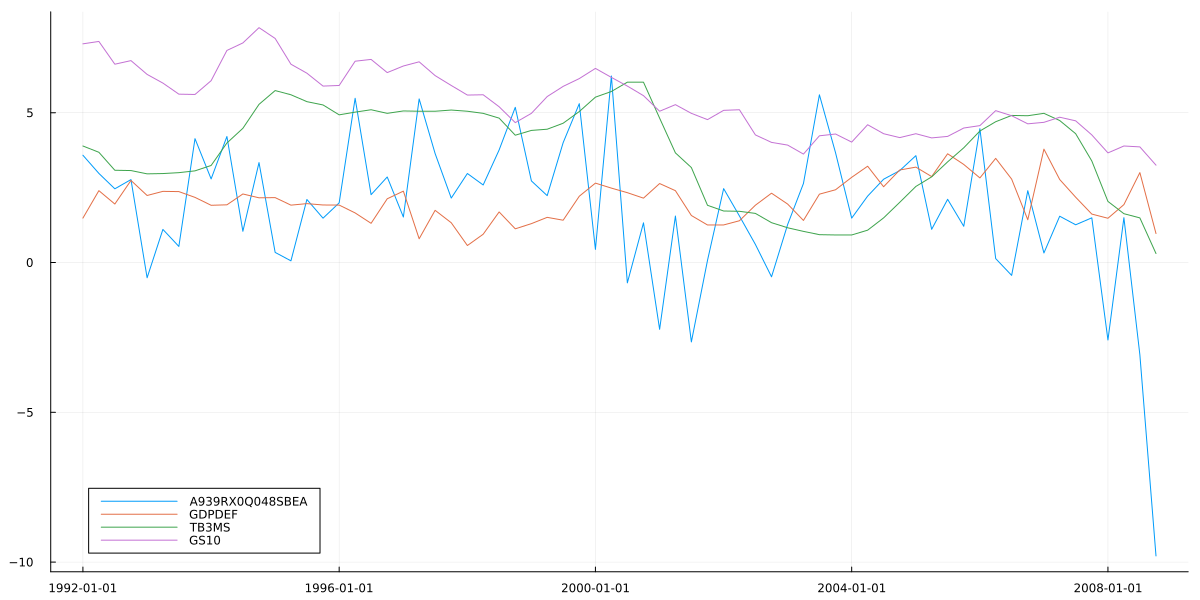

In [85]:
plot(data; size=(1200, 600))

In [86]:
presample_mean = mean(presample)
presample_mean = round.(presample_mean, digits=2)
display("presample mean")
display(presample_mean)

presample_variance = var(presample)
presample_variance = round.(presample_variance, digits=2)
display("presample variance")
display(presample_variance)
display(presample_variance .^ .5) 

BoundsError: BoundsError: attempt to access 0-element Vector{Date} at index [0]

In [87]:
n = 4 #number of observatin variables

priors = (
        initial_trend_mean = values(presample_mean)[1,:],
        initial_cycle_mean = zeros(n),
        initial_trend_covariance = diagm(fill(1,n)),
        trend_covariance_df = 100,
        trend_covariance_mean = diagm([2.5, 5, 5, 5] ./ 400),
        cycle_coeff_mean = zeros(n, n),
        cycle_coeff_shrinkage_param = .2,
        cycle_covariance_mean = diagm(values(presample_variance)[1,:]), #diagm(presample_variance), 
        cycle_covariance_df = n+2
        )


(initial_trend_mean = [1.01, 2.46, 0.16, 0.88], initial_cycle_mean = [0.0, 0.0, 0.0, 0.0], initial_trend_covariance = [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1], trend_covariance_df = 100, trend_covariance_mean = [0.00625 0.0 0.0 0.0; 0.0 0.0125 0.0 0.0; 0.0 0.0 0.0125 0.0; 0.0 0.0 0.0 0.0125], cycle_coeff_mean = [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], cycle_coeff_shrinkage_param = 0.2, cycle_covariance_mean = [24.98 0.0 0.0 0.0; 0.0 2.18 0.0 0.0; 0.0 0.0 3.19 0.0; 0.0 0.0 0.0 0.25], cycle_covariance_df = 6)

In [88]:
priors.cycle_covariance_mean

4×4 Matrix{Float64}:
 24.98  0.0   0.0   0.0
  0.0   2.18  0.0   0.0
  0.0   0.0   3.19  0.0
  0.0   0.0   0.0   0.25

In [192]:
observation_tend_mapping  = [1 0 0 0 
                             0 1 0 0 
                             0 1 1 0 
                             0 1 1 1 ]

trend_states_samples, cycle_states_samples, trend_covariance_samples, betas_samples, sigmas_samples = TCVAR.gibs_sampler(values(data), observation_tend_mapping, priors; burnin = 50_000, n_samples = 50_000, thin=25)

trend_states_mean, trend_states_lower, trend_states_upper = TCVAR.compute_posterior_statistics(trend_states_samples, credible_level=0.68)  
cycle_states_mean, cycle_states_lower, cycle_states_upper = TCVAR.compute_posterior_statistics(cycle_states_samples, credible_level=0.95) 

([1.6261007261240847 -0.8220242877815344 0.017493374197507714 1.5842351653754796; 1.0189383732974586 0.09324110366397523 -0.20972895073568507 1.6397642743078618; … ; -4.193101772372538 0.8655417891840395 -1.4310376676582217 -0.5659680927449372; -10.896493415609273 -1.130252945067578 -2.5660122453804677 -1.1213280553900666], [0.7925320312553616 -1.7590092163121076 -1.1358962968834763 -0.1748589688300805; 0.20045931600662606 -0.8254726682770536 -1.3618743916474583 -0.15222516948636827; … ; -5.1697775219214295 -0.05046110161065296 -2.94211058473474 -3.1477083593109354; -11.902247572158604 -2.0758819115553946 -4.133748997020257 -3.783293902653601], [2.574919958129675 0.014532964864896318 1.2403097317613232 3.610276207508029; 1.9518581022457124 0.9026774982847848 1.0030999520120654 3.6044169820100684; … ; -3.1889013604800667 1.858540332547636 -0.0920666528310349 1.740427342365673; -9.887125534959727 -0.1134558108789411 -1.1578564244261926 1.2740554516801352])

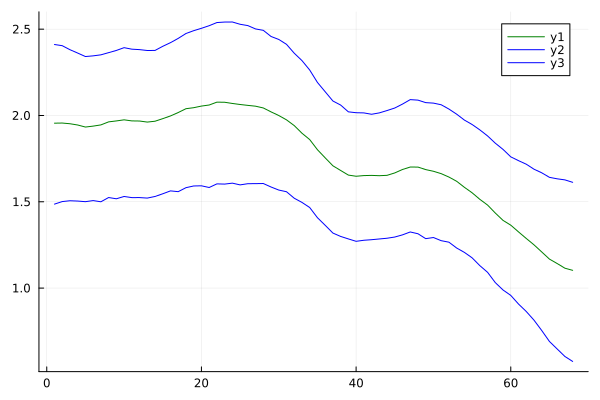

In [193]:
st = 1
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

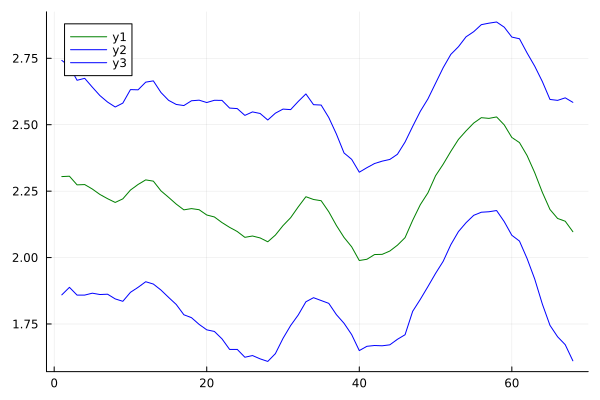

In [194]:
st = 2
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

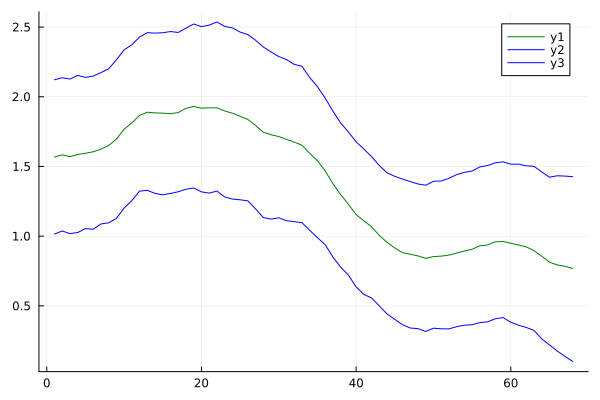

In [195]:
st = 3
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

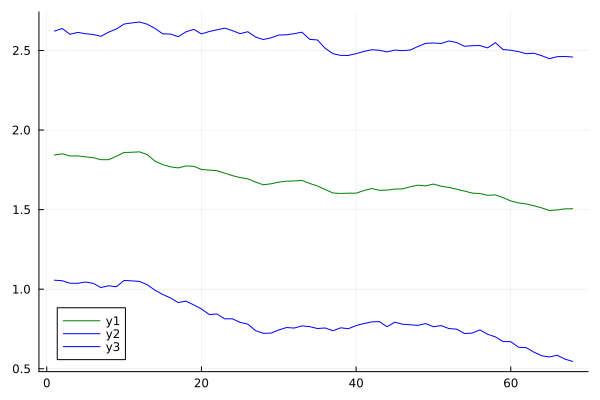

In [196]:
st = 4
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

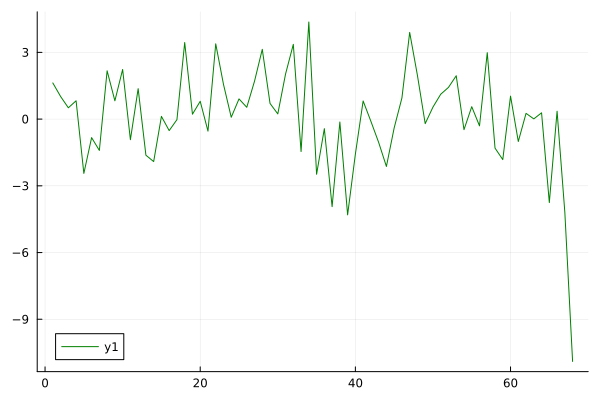

In [197]:
st=1
plot(cycle_states_mean[:,st], color="green" )

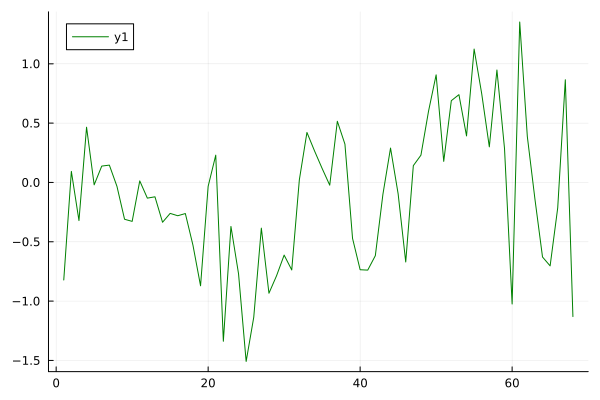

In [198]:
st=2
plot(cycle_states_mean[:,st], color="green" )

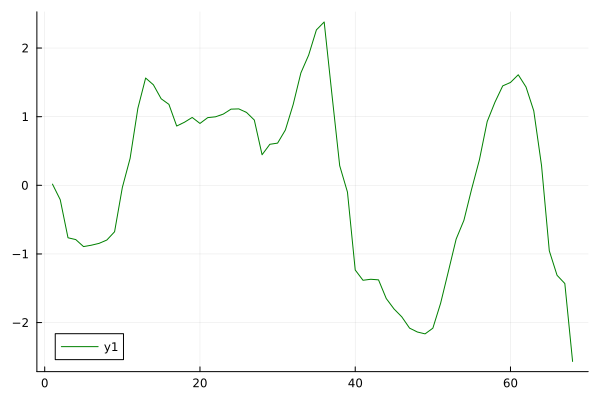

In [199]:
st=3
plot(cycle_states_mean[:,st], color="green" )

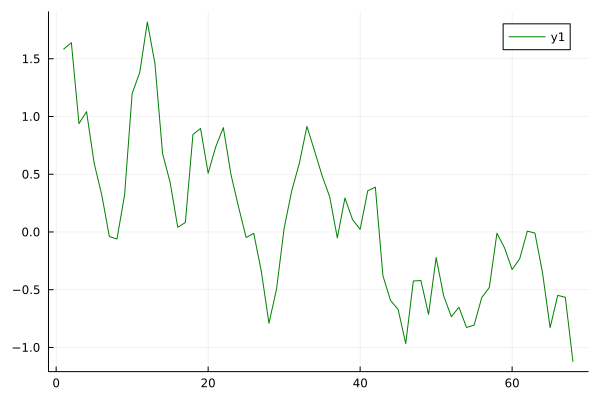

In [200]:
st=4
plot(cycle_states_mean[:,st], color="green" )

In [201]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         Στ1    0.0075    0.0013    0.0000   1950.8637   1711.1239    0.9996   ⋯
         Στ2    0.0001    0.0012    0.0000   2131.0006   1962.7334    1.0009   ⋯
         Στ3    0.0003    0.0012    0.0000   1945.6011   1724.3631    1.0005   ⋯
         Στ4    0.0001    0.0011    0.0000   1990.1218   1819.6342    1.0002   ⋯
         Στ5    0.0001    0.0012    0.0000   2131.0006   1962.7334    1.0009   ⋯
         Στ6    0.0145    0.0023    0.0001   1874.8155   1960.6676    0.9999   ⋯
         Στ7    0.0002    0.0016    0.0000   1723.2663   1650.8478    1.0004   ⋯
         Στ8    0.0001    0.0016    0.0000   1801.0506   1850.2635    0.9996   ⋯
         Στ9    0.0003    0.0012    0.0000   1945.6011   1724.3631    1.0005   ⋯
        Στ10    0.0002    0.0016    0.0000   1723.2663   1650.8478    1.0004   ⋯
        

In [202]:
summarystats(betas_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         Σc1    0.0719    0.1069    0.0026   1675.4723   1808.5356    0.9998   ⋯
         Σc2   -0.1979    0.3707    0.0081   2071.0110   1777.1308    1.0012   ⋯
         Σc3    0.0171    0.2401    0.0055   1891.8331   1786.0302    0.9996   ⋯
         Σc4   -0.0918    0.5116    0.0116   1935.2216   1925.6653    1.0000   ⋯
         Σc5    0.0143    0.0366    0.0008   2077.2435   2003.4620    0.9996   ⋯
         Σc6    0.1784    0.1401    0.0031   2028.2022   1918.2332    0.9995   ⋯
         Σc7   -0.0233    0.0880    0.0020   1846.5923   1884.2719    0.9999   ⋯
         Σc8    0.0091    0.2083    0.0047   1990.0293   1922.3943    1.0009   ⋯
         Σc9    0.0240    0.0416    0.0010   1907.2835   1848.3373    1.0001   ⋯
        Σc10    0.0214    0.1434    0.0034   1780.2103   1741.7408    1.0019   ⋯
        

In [203]:
summarystats(sigmas_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         Σc1    9.4258    1.6525    0.0364   2072.9716   1921.8610    0.9999   ⋯
         Σc2    0.1097    0.4046    0.0090   2016.3388   1875.4368    1.0000   ⋯
         Σc3    0.3988    0.4729    0.0110   1828.1956   2040.2245    1.0027   ⋯
         Σc4    0.3267    0.4536    0.0102   1939.4747   1890.9935    0.9999   ⋯
         Σc5    0.1097    0.4046    0.0090   2016.3388   1875.4368    1.0000   ⋯
         Σc6    1.0363    0.3498    0.0079   1950.9624   1959.3457    1.0006   ⋯
         Σc7    0.0957    0.1846    0.0042   1933.4527   1761.7941    1.0006   ⋯
         Σc8    0.1632    0.3300    0.0074   1990.9597   1937.9355    1.0009   ⋯
         Σc9    0.3988    0.4729    0.0110   1828.1956   2040.2245    1.0027   ⋯
        Σc10    0.0957    0.1846    0.0042   1933.4527   1761.7941    1.0006   ⋯
        

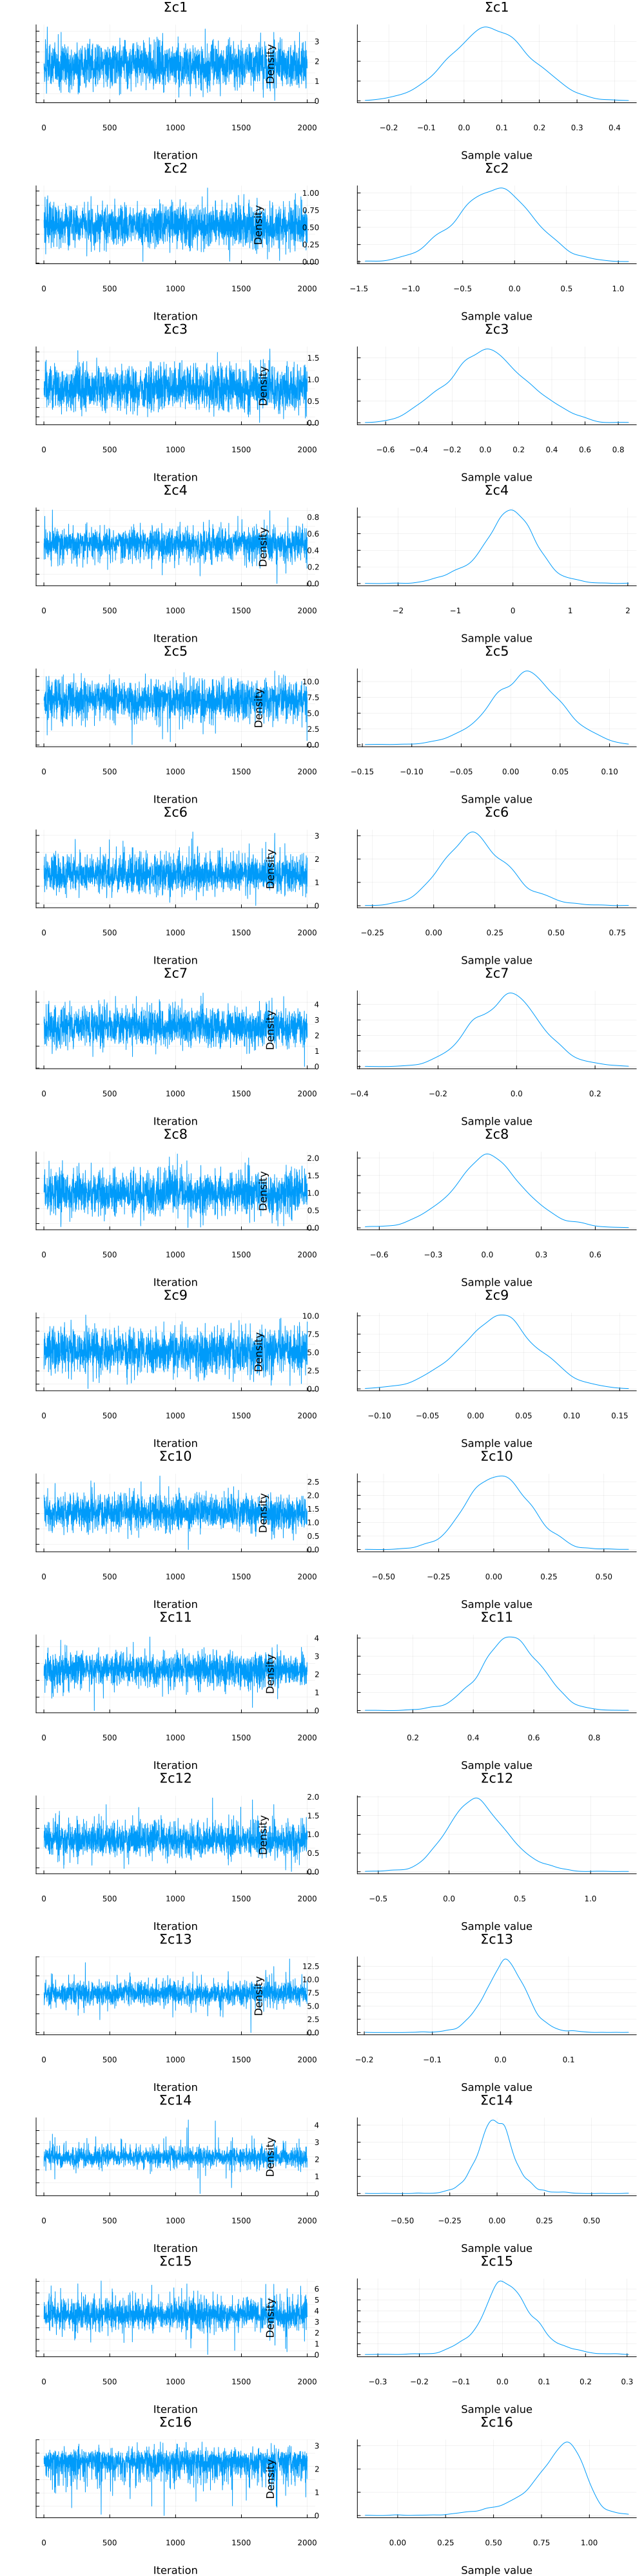

In [204]:
plot(betas_samples)

In [205]:
Σc = mean(sigmas_samples).nt.mean
Σc = reshape(Σc, n, n)
display(Σc)

β = mean(betas_samples).nt.mean
β = reshape(β, n, n*1)
display(β)

Στ = mean(trend_covariance_samples).nt.mean
Στ = reshape(Στ, 4, 4)
display(Στ)

4×4 Matrix{Float64}:
 9.4258    0.109663    0.398786    0.326655
 0.109663  1.03627     0.0957002   0.163192
 0.398786  0.0957002   1.40999    -0.0589499
 0.326655  0.163192   -0.0589499   0.829314

4×4 Matrix{Float64}:
  0.0718977   0.0143469   0.0239576   0.00763054
 -0.197915    0.178364    0.0214019  -0.00545703
  0.0171322  -0.0233435   0.524248    0.0147524
 -0.09176     0.00914843  0.208784    0.812747

4×4 Matrix{Float64}:
 0.00747227   0.000101235  0.000299504  5.11945e-5
 0.000101235  0.0144694    0.000183995  0.000122864
 0.000299504  0.000183995  0.0147195    0.000154327
 5.11945e-5   0.000122864  0.000154327  0.0142095

In [206]:
display(diag(Σc) .^ .5)

display(diag(Στ) .^ .5)

4-element Vector{Float64}:
 3.0701462964879864
 1.0179744510449065
 1.1874301281728639
 0.9106667306970015

4-element Vector{Float64}:
 0.08644228833149643
 0.12028874811393546
 0.12132408465522716
 0.11920352384662937

In [207]:
model = tc_var(observation_tend_mapping, β, Στ, Σc, priors.initial_trend_mean, priors.initial_cycle_mean, priors.initial_trend_covariance, priors.cycle_covariance_mean)

initial_states = [trend_states_mean[end,:]; cycle_states_mean[end,:]]

n_samples = 2_000
T = 100
states = zeros(n_samples, T, 8)

observations = zeros(n_samples, T, n)

for s in 1:2_000
    states[s, :, :], observations[s, :, :] = sample(model, initial_states, T)
end


In [208]:
transformed_scenarios = permutedims(observations, (3, 2, 1))[[1,2],:,:] ./400
periods = [1, 5, 10, 25]
freq = 4
assets_names = ["GDP", "CPI"]
ret_in_years = cum_returns_in_periods(transformed_scenarios, periods, freq, true)
print_scenarios_summary(ret_in_years, assets_names, string.(periods))

for a in 1:2
    print_scenarios_percentiles(ret_in_years[a, :, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), string.(assets_names[a]))
end  

Means 
 
 
 
 GDP 
 CPI 
 
 
 
 
 1 
 -0.0186 
 0.0244 
 
 
 5 
 0.0052 
 0.0217 
 
 
 10 
 0.0082 
 0.0213 
 
 
 25 
 0.01 
 0.0211

Standard devations 
 
 
 
 GDP 
 CPI 
 
 
 
 
 1 
 0.0142 
 0.0057 
 
 
 5 
 0.0074 
 0.0043 
 
 
 10 
 0.0059 
 0.0048 
 
 
 25 
 0.0059 
 0.007

Skewness 
 
 
 
 GDP 
 CPI 
 
 
 
 
 1 
 0.0032 
 -0.1033 
 
 
 5 
 -0.0166 
 0.0837 
 
 
 10 
 0.0352 
 0.0456 
 
 
 25 
 -0.0297 
 -0.0428

Kurtosis 
 
 
 
 GDP 
 CPI 
 
 
 
 
 1 
 -0.1596 
 0.0492 
 
 
 5 
 -0.0404 
 0.1901 
 
 
 10 
 -0.0536 
 0.1303 
 
 
 25 
 0.033 
 0.0177

GDP 
 
 
 
 0.01 
 0.025 
 0.05 
 0.25 
 0.5 
 0.75 
 0.95 
 0.975 
 0.99 
 
 
 
 
 1 
 -0.0508 
 -0.0467 
 -0.0424 
 -0.0282 
 -0.0188 
 -0.0091 
 0.0048 
 0.0089 
 0.0136 
 
 
 5 
 -0.0122 
 -0.009 
 -0.0068 
 0.0004 
 0.0051 
 0.0102 
 0.0175 
 0.0195 
 0.0217 
 
 
 10 
 -0.0053 
 -0.0032 
 -0.0015 
 0.0041 
 0.0081 
 0.0124 
 0.018 
 0.0197 
 0.0223 
 
 
 25 
 -0.004 
 -0.0016 
 0.0003 
 0.0061 
 0.01 
 0.014 
 0.0195 
 0.0215 
 0.0235

CPI 
 
 
 
 0.01 
 0.025 
 0.05 
 0.25 
 0.5 
 0.75 
 0.95 
 0.975 
 0.99 
 
 
 
 
 1 
 0.0104 
 0.0128 
 0.015 
 0.0207 
 0.0244 
 0.0283 
 0.0335 
 0.0352 
 0.0372 
 
 
 5 
 0.0115 
 0.0133 
 0.0146 
 0.0188 
 0.0216 
 0.0244 
 0.0288 
 0.0306 
 0.0325 
 
 
 10 
 0.0101 
 0.012 
 0.0136 
 0.0181 
 0.0212 
 0.0244 
 0.0292 
 0.0306 
 0.0325 
 
 
 25 
 0.0052 
 0.0069 
 0.0091 
 0.0165 
 0.0213 
 0.0258 
 0.0325 
 0.0348 
 0.0367

In [209]:
transformed_scenarios = permutedims(observations[:,:,[3,4]] , (3, 2, 1))
freq = 4

transformed_scenarios = transformed_scenarios[:,freq:freq:end,:]

periods = [1, 5, 10, 25]


assets_names = ["ShortRate", "LongRate"]
ret_in_years = transformed_scenarios = transformed_scenarios[:,periods,:]
print_scenarios_summary(ret_in_years, assets_names, string.(periods))

for a in 1:2
    print_scenarios_percentiles(ret_in_years[a, :, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), string.(assets_names[a]))
end  

Means 
 
 
 
 ShortRate 
 LongRate 
 
 
 
 
 1 
 2.4446 
 3.7562 
 
 
 5 
 2.8653 
 4.3058 
 
 
 10 
 2.9083 
 4.3241 
 
 
 25 
 2.8892 
 4.3742

Standard devations 
 
 
 
 ShortRate 
 LongRate 
 
 
 
 
 1 
 1.4512 
 1.4163 
 
 
 5 
 1.5862 
 1.9793 
 
 
 10 
 1.7567 
 2.1658 
 
 
 25 
 2.2728 
 2.761

Skewness 
 
 
 
 ShortRate 
 LongRate 
 
 
 
 
 1 
 0.0833 
 -0.0493 
 
 
 5 
 -0.0868 
 -0.002 
 
 
 10 
 -0.0827 
 0.0177 
 
 
 25 
 0.0062 
 -0.1664

Kurtosis 
 
 
 
 ShortRate 
 LongRate 
 
 
 
 
 1 
 -0.0366 
 0.1913 
 
 
 5 
 0.1137 
 -0.0775 
 
 
 10 
 0.0069 
 -0.0747 
 
 
 25 
 0.1051 
 -0.0383

ShortRate 
 
 
 
 0.01 
 0.025 
 0.05 
 0.25 
 0.5 
 0.75 
 0.95 
 0.975 
 0.99 
 
 
 
 
 1 
 -0.822 
 -0.3193 
 0.072 
 1.4345 
 2.425 
 3.4168 
 4.8929 
 5.393 
 5.9923 
 
 
 5 
 -0.9151 
 -0.2938 
 0.1874 
 1.8507 
 2.8668 
 3.8968 
 5.4908 
 5.9122 
 6.3474 
 
 
 10 
 -1.3583 
 -0.6969 
 0.0072 
 1.7017 
 2.938 
 4.0564 
 5.7905 
 6.3024 
 6.9558 
 
 
 25 
 -2.5365 
 -1.5544 
 -0.8535 
 1.3316 
 2.8778 
 4.4225 
 6.6742 
 7.309 
 8.0443

LongRate 
 
 
 
 0.01 
 0.025 
 0.05 
 0.25 
 0.5 
 0.75 
 0.95 
 0.975 
 0.99 
 
 
 
 
 1 
 0.4075 
 0.938 
 1.4168 
 2.8221 
 3.7383 
 4.6929 
 6.0769 
 6.5456 
 7.0622 
 
 
 5 
 -0.3729 
 0.4515 
 0.9968 
 2.9869 
 4.2797 
 5.6645 
 7.5461 
 8.14 
 8.9939 
 
 
 10 
 -0.6787 
 0.1572 
 0.8767 
 2.7541 
 4.3202 
 5.7604 
 7.9462 
 8.6536 
 9.3325 
 
 
 25 
 -2.45 
 -1.2104 
 -0.2812 
 2.584 
 4.5018 
 6.2106 
 8.838 
 9.6798 
 10.3462

In [210]:
n_observations = size(model.T,1)
n_trends = 4
n_time_steps = size(data,1)
n_draws = 1000
trends_states = zeros(n_draws, n_time_steps, n_trends)

for s in 1:n_draws
    state_smoothed_samples = carter_kohn_sampler(model, values(data))
    trends_states[s,:,:] = state_smoothed_samples[:, 1:n_trends]
end

trend_states_mean, trend_states_lower, trend_states_upper = TCVAR.compute_posterior_statistics(trend_states_samples, credible_level=0.95) 

([1.9553711977392672 2.304821230447381 1.5677141612081722 1.8432264899886701; 1.9561663300944074 2.3062171910966134 1.583481106396103 1.8505603744456902; … ; 1.1151400589450438 2.1367646134018212 0.7842590427287055 1.5049368743076874; 1.1028363296157024 2.0974195101881543 0.7685927483559452 1.505315817071111], [1.0048185457998857 1.4657839087973894 0.3569904761996053 0.1715514547444499; 1.021646711503524 1.4983839473188405 0.3605733663066842 0.15359808541580533; … ; 0.11014442918495831 1.1446978624197504 -0.5596677983361614 -0.4968424777814799; 0.09346613459885207 1.0806207104871934 -0.5622849631724355 -0.4693794589242389], [2.788958830065474 3.2402546327335346 2.5803090908531856 3.3976584585837446; 2.7763392429409857 3.2240102939089694 2.61177352381515 3.4156082262440797; … ; 2.091713101574721 3.0538434286292118 2.1426762473001046 3.6481519544582905; 2.1085931501963193 3.0430503256658765 2.1505296978625084 3.6860103250080862])

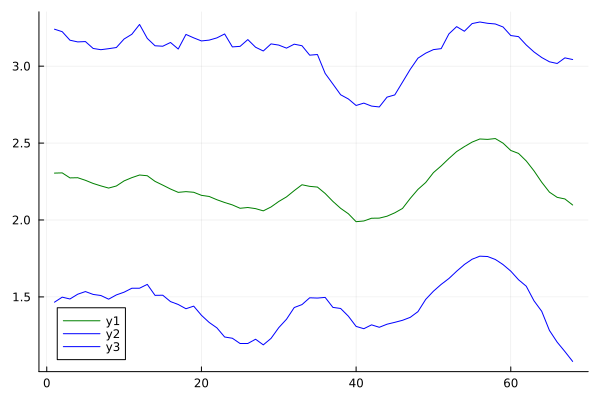

In [211]:
st = 2
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

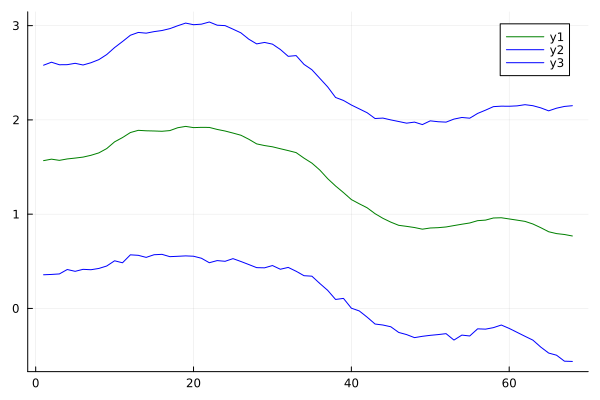

In [212]:
st = 3
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")